# Implementación K-means
K-means
    Elegir instacias del dataset como centroides iniciales
    Distirbuir puntos del dataset a los centroides
    Calcular la media de las distancias respecto de los puntos
    Se recalculaba el centroide 
    Repetir hasta que no haya cambios
    
Estaría bien usar la misma interfaz que sckikit learn
Kmeans = Kmeans(K=5)
Kmeans.fit(X)
Kmeans.predict(X)

Tenemos un conjunto de datos, eliges el numero de clusters (n_clusters), asignas los centroides a unos datos aleatoriamente (init -> puntos aleatorios del dataset), y después asignas los datos a los clusters (asignar_clusters). Después hay que computar los nuevos centroides en un bucle y volver a asignar los clusters hasta que se cumpla la condición de parada.

In [24]:
# con la librería de SciKit Learn:
import sklearn
from sklearn.cluster import KMeans

kmeans = KMeans()
#kmeans.fit(X)
#kmeans.predict(X)

In [25]:
import numpy as np
import math
from math import dist
import statistics as s
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import random

In [26]:
x, y = make_blobs()
print(x.shape[1])
print("EQUIS: \n", x)
print("Y: \n", y)

2
EQUIS: 
 [[ 6.45793408  2.24699967]
 [ 5.7619233   4.64908308]
 [ 4.63577796  4.60262953]
 [-4.90462379 -0.42839617]
 [ 7.08796381  5.3305788 ]
 [-3.6873608  -0.51129302]
 [ 6.04930422  2.12854567]
 [-5.16863523 -1.34837923]
 [-4.91455587 -2.67511534]
 [-3.58370455  1.46530374]
 [ 6.02365127  3.41668049]
 [ 7.21238821  5.32093961]
 [ 5.00351361  4.89724015]
 [ 5.19734885  2.45237081]
 [-2.92496709  0.36468505]
 [ 3.18716994  4.89805029]
 [ 5.55645701  5.70312009]
 [-2.91236085  0.891284  ]
 [-3.15390996 -1.04364142]
 [ 6.29591353  4.8479599 ]
 [ 4.52358905  3.04884592]
 [-3.59280407  1.84574786]
 [ 6.52249475  7.43146732]
 [-0.48054919  0.4750127 ]
 [ 7.81630299  5.74853032]
 [ 3.32799875  5.55566132]
 [ 5.66056578  5.43278076]
 [ 5.7564831   6.67052612]
 [ 6.42215098  0.58700622]
 [ 5.35834052  3.6964319 ]
 [ 6.39465825  2.26006174]
 [ 5.68717264  2.49352346]
 [ 4.27559845  5.37461244]
 [ 6.39187202  2.8342156 ]
 [ 3.67878602  3.18018054]
 [ 3.09105923  5.52338799]
 [ 6.84798902  1.

In [27]:
len(x)

100

In [28]:
class KMeans_Ours():
    def __init__(self, n_clusters=8, max_iter=100, random_state=55):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.iter = 0
        self.random_state = random_state
        
        self.X= []
        
        self._centroids= []
        self._inertia=[]
        self._labels=[]
        self.history = {'iteration': [],
                        'centroids':  [],  
                        'labels' : [],
                        'inertia':  []
                        }
    
    def fit(self, X):
        """Este método entrena el modelo con el dataset proporcionado, aplicando el algoritmo de asignación de centroides"""
        self.X = X
        self._assign_centroids()
        self._assign_labels()
        # print("centroides iniciales: ", self._centroids)
        while not self._stop(): # si se llega a max iter o si centroides no cambian (con último valor de self.history), una u otra
            self._add_history_step() 
            # con esto podemos hacer un gráfico (no se pide pero quedaría rechulón)
            
            self._update_centroides()
            # print("history: ", self.history['centroids'][self.iter])
            self._assign_labels()
            
            self.iter += 1
            
    def return_centroids(self):
        return self._centroids
    
    def return_labels(self):
        return self._labels
    
    def predict(self, X):
        # contemplar posibilidad de triangulación
        predictions = []
        for row in X:
            min_distance = math.inf
            nearest_centroid = None
            for centroid_label in range(self.n_clusters):
                distance = dist(row, self._centroids[centroid_label])
                # print("distancia entre", row, "y", self._centroids[centroid_label], "es: ", distance, "con label", centroid_label)
                # print("distancia: ", distance, "\nmin_distancia: ", min_distance)
                if distance < min_distance:
                    # print("dentro if")
                    min_distance = distance
                    nearest_centroid = centroid_label
            predictions.append(nearest_centroid)
        return predictions
    
    def _assign_centroids(self):
        # utilizar el módulo random de numpy para asignar los centroides: check
        # sólo para la primera iteración (asignación de centroides iniciales): check
        # un centroide a la misma posición dato aleatoriamente 
        # con replace = false nos aseguramos de que no se repita el mismo valor para dos centroides diferentes,
        # de forma que todos los centroides tomen coordenadas distintas
        c_index = np.random.choice(list(range(0, len(self.X))), size = self.n_clusters, replace = False)
        # print(c_index)
        for i in c_index:
            self._centroids.append(self.X[i])
            # print("centroide ",i, ": ", self.X[i])
        # print(self._centroids)
        # asignar valores de los datos a los que equivalen esas posiciones en la tabla a los "centroides"        
    
    def _assign_labels(self):
        # función para asignar los datos a un centroides
        # linalg.norm -> normaliza los vectores, no calcula distancias como tal; no es lo que buscamos
        self._inertia = []
        self._labels = []
        
        # generación de la matriz
        for i in range(len(self.X)):
            self._inertia.append(self._compute_inertia(self.X[i]))
            
            # encasillamiento con labels de cada dato a su respectivo centroide 
            self._labels.append(np.argmin(self._inertia[i], axis = 0))
        
        
    def _stop(self):
        """ condición de parada del bucle de actualización de labels y centroides de función fit()
        si devuelve False, no se cumple la condición de parada. 
        si devuelve True sí se cumple la condición de parada: se para la ejecución"""
        # print("stop")
        
        # condición de parada por iteraciones, asegurando que la primera ejecución siempre ocurre 
        # (en history no hay nada, para que no compare y de error)
        if self.iter == self.max_iter: 
            return True
        if self.iter == 0:
            return False
        
        prev_centroids= self.history['centroids'][-1]
        cambia = [False] * self.n_clusters
        # print(self.history)
        # print("centroides previos: ", prev_centroids)
        # print("centroides actualizados: ", self._centroids)
        for i in range (self.n_clusters):
            #Si este centroide no cambia respecto del mismo en la anterior iteración, devolver True para este centroide
            if np.array_equal(self._centroids[i], prev_centroids[i]):
                # print("no ha cambiado el centroide ", i)
                cambia[i] = True
        #Si no hay diferencias, los centroides no han cambiado en la última iteración y se cumple la condición de parada.    
        # Es decir, si todos son iguales
        if False in cambia:
            return False
        return True
    
    def _update_centroides(self):
        # siguientes iteraciones para reposicionar los centroides
    
        for i in range(self.n_clusters):
            control= []
            for j in range(len(self.X)):
                if self._labels[j]==i:
                        control.append(self.X[j])
            #print("control list:", control)
            #print(np.mean(control))
            self._centroids[i]= np.mean(control, axis = 0)
        # print("centroides actualizados", self._centroids)
    
    def _compute_inertia(self, x):
        """ distancia entre el dato o row 'x' y cada centroide' """
        distance_row=[]
        
        for centroid in self._centroids: 
            #print(x, centroid)
            distance_row.append(dist(x,centroid))
       
        return distance_row
        
    def _add_history_step(self):
        """ actualización de historial de centroides para nueva iteración """
        # self.history es un array de diccionarios, cada uno con toda esta información
        self.history['iteration'].append(self.iter)
        self.history['centroids'].append(self._centroids.copy())
        self.history['labels'].append(self._labels.copy())
        self.history['inertia'].append(self._inertia.copy())
        
        # print("history: ", self.history['centroids'][self.iter])
        # print("centroides: ", self._centroids)
        
    def scatterplot_centroids(self):
        """creates a scatterplot with the final centroids
        only valid for self.X with 2 dimensions"""
        for i in range(self.n_clusters):
             plt.scatter(self._centroids[i][0], self._centroids[i][1])
    
    """
    def scatterplot_all(self):
        # actualmente este código funciona pero da muchísimos errores: revisar si se quiere incluir o se hará a mano
        # creación de n colores aleatorios por n_clusters
        
        colors = []
        for i in range(self.n_clusters):
            r = random.randint(0, 255) / 255.0
            g = random.randint(0, 255) / 255.0
            b = random.randint(0, 255) / 255.0
            colors.append((r, g, b))

        # Crear una lista de colores para cada punto en los datos
            for j in range(len(self.X)):
                if self._labels[j] == i:
                    plt.scatter(self.X[j][0], self.X[j][1], c=colors[i])
    """


In [29]:
kmeans = KMeans_Ours(n_clusters=3)
result = kmeans.fit(x)
kmeans.return_centroids()

[array([6.12666494, 1.95601874]),
 array([-3.74379369, -0.27908727]),
 array([5.6222093 , 5.25899569])]

In [30]:
print("centroides finales: ", kmeans.return_centroids())
print("número de iteraciones totales: ", kmeans.iter)

centroides finales:  [array([6.12666494, 1.95601874]), array([-3.74379369, -0.27908727]), array([5.6222093 , 5.25899569])]
número de iteraciones totales:  3


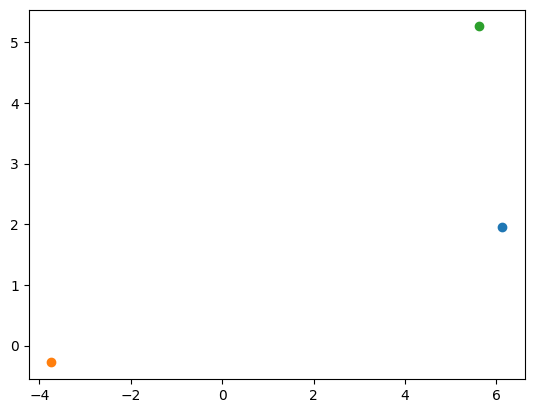

In [31]:
"""for i in range(3):
     plt.scatter(cent[i][0], cent[i][1])"""
kmeans.scatterplot_centroids()

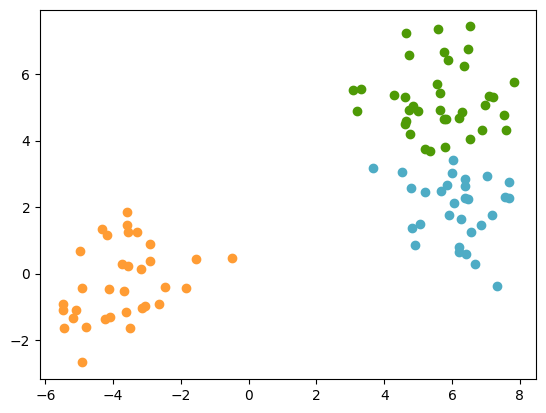

In [32]:
# kmeans.scatterplot_all()
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans.n_clusters):
    for j in range(len(x)):
        if kmeans._labels[j] == i:
            plt.scatter(x[j][0], x[j][1], c=colors[i])

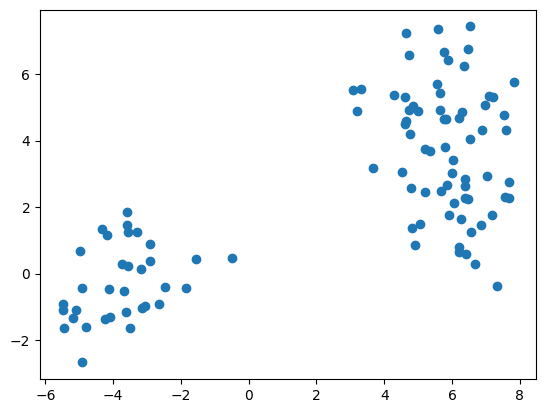

In [33]:
plt.scatter(x[:, 0], x[:, 1])

In [34]:
dist(kmeans.predict(x), kmeans.return_labels())
#print(len(kmeans.return_labels()), len(kmeans.predict(x)))

0.0

# con estrellas


In [2]:
import pandas as pd
stars = pd.read_csv('Stars2.csv')

In [3]:
print(stars.shape)
len(stars)

(240, 6)


240

In [4]:
stars.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


prueba: para ello necesitamos eliminar el color y la spectral class (sólo en este caso), en realidad: hacer Onehotencoding etc.

In [5]:
stars_prueba = stars.drop(columns = ["Color", "Spectral_Class"])
#stars.drop["Spectral_Class"]
stars_prueba

,Temperature,L,R,A_M
0,3068,0.002400,0.1700,16.12
1,3042,0.000500,0.1542,16.60
2,2600,0.000300,0.1020,18.70
3,2800,0.000200,0.1600,16.65
4,1939,0.000138,0.1030,20.06
...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93
236,30839,834042.000000,1194.0000,-10.63
237,8829,537493.000000,1423.0000,-10.73
238,9235,404940.000000,1112.0000,-11.23


In [6]:
# convert dataframe to array
stars_prueba_array = stars_prueba.values
stars_prueba_array

array([[ 3.06800e+03,  2.40000e-03,  1.70000e-01,  1.61200e+01],
       [ 3.04200e+03,  5.00000e-04,  1.54200e-01,  1.66000e+01],
       [ 2.60000e+03,  3.00000e-04,  1.02000e-01,  1.87000e+01],
       [ 2.80000e+03,  2.00000e-04,  1.60000e-01,  1.66500e+01],
       [ 1.93900e+03,  1.38000e-04,  1.03000e-01,  2.00600e+01],
       [ 2.84000e+03,  6.50000e-04,  1.10000e-01,  1.69800e+01],
       [ 2.63700e+03,  7.30000e-04,  1.27000e-01,  1.72200e+01],
       [ 2.60000e+03,  4.00000e-04,  9.60000e-02,  1.74000e+01],
       [ 2.65000e+03,  6.90000e-04,  1.10000e-01,  1.74500e+01],
       [ 2.70000e+03,  1.80000e-04,  1.30000e-01,  1.60500e+01],
       [ 3.60000e+03,  2.90000e-03,  5.10000e-01,  1.06900e+01],
       [ 3.12900e+03,  1.22000e-02,  3.76100e-01,  1.17900e+01],
       [ 3.13400e+03,  4.00000e-04,  1.96000e-01,  1.32100e+01],
       [ 3.62800e+03,  5.50000e-03,  3.93000e-01,  1.04800e+01],
       [ 2.65000e+03,  6.00000e-04,  1.40000e-01,  1.17820e+01],
       [ 3.34000e+03,  3.

In [7]:
kmeans_stars_prueba = KMeans_Ours()
result = kmeans_stars_prueba.fit(stars_prueba_array)
print(kmeans_stars_prueba.return_centroids())
print(kmeans_stars_prueba.iter)

NameError: name 'KMeans_Ours' is not defined

In [8]:
plt.scatter(stars_prueba_array[:, 0], stars_prueba_array[:, 1], stars_prueba_array[:, 2], stars_prueba_array[:, 3])

NameError: name 'plt' is not defined

In [9]:
colors = ["#FF9C34", "#4E9A06", "#DEB887", "#65B199", "#BDD4EE", "#3F567A", "#526AD5", "#00D542"]
for i in range(kmeans_stars_prueba.n_clusters):
    for j in range(len(stars_prueba_array)):
        if kmeans_stars_prueba._labels[j] == i:
            # aquí hay que hacer lo de reducir a sólo dos dimensiones para poder hacer el scatterplot 
            # (sólo deja con dos dimensiones)
            plt.scatter(stars_prueba_array[j][0], stars_prueba_array[j][1], c = colors[i])

NameError: name 'kmeans_stars_prueba' is not defined

# II. Preprocesado de Datos
En esta sección se preprocesa el dataset proporcionado, aplicando procesamiento de features de tipo One-ot-encodign y codificación ordinal, así como transformación de la dimensionalidad de los datos mediante PCA. 

## 1. One hot encoding 
En primer lugar aplicamos la técnica one-hot-encoding sobre las columnas categóricas. 

In [10]:
stars.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


In [11]:
stars_1hot= stars.copy()
#1. One hot encoding de color

for color in stars['Color'].unique():
    labels= []
    #Iteramos 1 vez por fila
    for i in stars['Color']:
        if i==color:
            labels.append(1)
        else:
            labels.append(0)
    stars_1hot[color]= labels
    
stars_1hot


,Temperature,L,R,A_M,Color,Spectral_Class,Red,Blue White,White,Yellowish White,...,Blue-white,Whitish,yellow-white,Orange,White-Yellow,white,yellowish,Yellowish,Orange-Red,Blue-White
0,3068,0.002400,0.1700,16.12,Red,M,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3042,0.000500,0.1542,16.60,Red,M,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2600,0.000300,0.1020,18.70,Red,M,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2800,0.000200,0.1600,16.65,Red,M,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1939,0.000138,0.1030,20.06,Red,M,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
236,30839,834042.000000,1194.0000,-10.63,Blue,O,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237,8829,537493.000000,1423.0000,-10.73,White,A,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
238,9235,404940.000000,1112.0000,-11.23,White,A,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#2. One hot encoding de Clase espectral
for spectral in stars['Spectral_Class'].unique():
    labels= []
    #Iteramos 1 vez por fila
    for i in stars['Spectral_Class']:
        if i==spectral:
            labels.append(1)
        else:
            labels.append(0)
    stars_1hot[spectral]= labels
    
stars_1hot

,Temperature,L,R,A_M,Color,Spectral_Class,Red,Blue White,White,Yellowish White,...,Yellowish,Orange-Red,Blue-White,M,B,A,F,O,K,G
0,3068,0.002400,0.1700,16.12,Red,M,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,3042,0.000500,0.1542,16.60,Red,M,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2600,0.000300,0.1020,18.70,Red,M,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,2800,0.000200,0.1600,16.65,Red,M,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1939,0.000138,0.1030,20.06,Red,M,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
236,30839,834042.000000,1194.0000,-10.63,Blue,O,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
237,8829,537493.000000,1423.0000,-10.73,White,A,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
238,9235,404940.000000,1112.0000,-11.23,White,A,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [13]:
stars['Color'].unique()
stars['Spectral_Class'].unique()

array(['M', 'B', 'A', 'F', 'O', 'K', 'G'], dtype=object)

## 2. Ordinal Scale Encoding
En esta segunda variante, convertimos las variables categóricas a escalas ordinales. 

In [14]:
stars_ordinal= stars.copy()
spectral_class=["M", "K","G", "F","A","B","O"]
labels= []
    #Iteramos 1 vez por fila
for i in stars['Spectral_Class']:
    labels.append(spectral_class.index(i))
       
stars_ordinal['Spectral_Class']= labels
    
stars_ordinal


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,0
1,3042,0.000500,0.1542,16.60,Red,0
2,2600,0.000300,0.1020,18.70,Red,0
3,2800,0.000200,0.1600,16.65,Red,0
4,1939,0.000138,0.1030,20.06,Red,0
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,6
236,30839,834042.000000,1194.0000,-10.63,Blue,6
237,8829,537493.000000,1423.0000,-10.73,White,4
238,9235,404940.000000,1112.0000,-11.23,White,4


In [23]:
color_means=[]
for color in stars['Color'].unique():
    aux= False
    i=0
    temp= stars[stars['Color']==color]['Temperature'].mean().round(2)
    """for i in color_means:
        if temp <= i['Temperature']:
            color_means.insert(color_means.index(i), {'Color': color, 'Temperature': temp})"""
        

color_means
                
        

[]

In [16]:

stars.loc[stars['Color']=="White-Yellow",'Color']
stars.loc[stars['Color']=="White",'Color']
stars.loc[stars['Color']=="Yellow",'Color']
stars.loc[stars['Color']=="Red",'Color']

stars
    
    #if row['Color']== "Red":
        #row['Color']=4
    
#stars.head()
    

,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M
...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Blue,O
237,8829,537493.000000,1423.0000,-10.73,White,A
238,9235,404940.000000,1112.0000,-11.23,White,A


### PRUEBAS

In [ ]:
import statistics as s
hola = [1, 2, 3]
s.mean(hola)
array1 = np.array([1, 2, 3])
array2 = np.array([4, 5, 6])
todos = []
todos.append(array1)
todos.append(array2)
print(todos)
# Calcular la media de los dos arrays
media_arrays = np.mean(todos, axis = 0)
media_arrays

In [ ]:
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for i in range(kmeans.n_clusters):
    for j in range(len(x)):
        if kmeans._labels[j] == i:
            plt.scatter(x[j][0], x[j][1], c=colors[i])



In [ ]:
print(hola)
print(hola[-1])

In [ ]:
print(np.random.choice(list(range(0, len(stars))), size = 5, replace = False))

In [ ]:
X = np.random.random(size = (100, 2))
centroide = np.random.random_integers(0, len(X))
centroide
len(X)

In [ ]:
centroids = []
centroids = np.random.choice(range(0, len(X)), size = 8, replace = False)
centroids

In [ ]:
matriz = [1, 2, [3, 4], [5, 6]]
print(matriz[0][2], matriz[2][1])

In [ ]:
matriz_distancias = []
for i in range(len(X)):
    matriz_distancias.append([])
    for j in range(7):
         matriz_distancias[i].append(np.random.randint(1, 10))



In [ ]:
labels_=[]
for i in range(len(matriz_distancias)):
    labels_.append(np.argmin(matriz_distancias[i], axis = 0))

labels_

In [ ]:
np.random.randint(1, 10)

In [ ]:
np.argmin(matriz_distancias, axis=0)

In [ ]:
kmeans = KMeans()
kmeans.fit(X)

Scikit learn es una librería de código abierto, se puede ver cómo está implementado en Scikit learn, no copiar la misma solución, pero usarlo como inspiración. Hay un apartado de indicar similitud con scikit learn.

## PCA
Algoritmo no supervisado muy útil, reduce la dimensionalidad de los datos (columnas). En lugar de eliminar columnas, existen métodos más interesantes que ese.
Prdecir el número escrito en el gráfico en base a la luminosidad de los píxeles. Se ve bien con cmap = 'Greys'.

Se usará el algoritmo PCA antes del algoritmo de clustering, y el de clustering se usará sobre las dos dimensiones que devuelve PCA (kmeans o lo que sea)

In [ ]:
from sklearn.datasets import load_digits
import matplotlib.pylot as plt

from sklearn.decomposition import PCA

X = load.digits().data
X.shape
plt.imshow(np.reshape(X[0], (8,8)))
pca = PCA.fit(X)
plt.plot

In [ ]:
X_pca

# Pruebas fallidas...

In [ ]:
"""self.history.centroids
        
        for i in range(self.n_clusters):
            centroide = np.random.random_integers(0, len(self.X)-1, size=self.n_clusters)
            
            for c in centroide:
                if centroide.count(c) == 1:
                    self.history.centroids.append(X[c])
                else:
                    centroide[c] = np.random.random_integers(0, len(self.X)-1)
                    while centroide
            
            duplicate = False
            while self.history.centroids du
            if i>0:
                for i in range(len(self.history.centroids)):
                    if centroide == self.history.centroids[i]:
                        
            self.history.centroids.append(np.)"""